In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
os.chdir(r"C:\Users\User\OneDrive\Документы\Kaggle\kaggle\AI for agriculture 2025")
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.utils.data import Subset
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
import os
from pathlib import Path
import re
from sklearn.decomposition import IncrementalPCA
from sklearn.compose import ColumnTransformer
import pickle
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, sum_models, Pool

In [2]:
def dump(estimator, name):
    with open(f"{name}.pkl", "wb") as f:
        pickle.dump(estimator, f)
def load(name):
    with open(f"{name}.pkl", "rb") as f:
        return pickle.load(f)

In [3]:
class AgriImageDataset(Dataset):
    def __init__(self, root_dir, num_channels=125, transform=None, include_pca=True):
        self.root_dir = Path(root_dir)
        self.train_dir = Path(self.root_dir) / "ot" / "ot"
        self.num_channels = num_channels
        self.transform = transform
        self.include_pca = include_pca
        if self.include_pca:
            self.pca = load("ipca")
        self.items_faulty = pd.read_csv("faulty_images.csv").values
        self.samples = []
        labels = pd.read_csv(self.root_dir / "train.csv")
        for label in labels.values:
            if int(re.findall(r'\d+', label[0])[0]) in self.items_faulty:
                continue
            self.samples.append((self.train_dir / label[0], label[1]))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, value = self.samples[idx]
        image = np.load(img_path).astype(float)
        image = image.transpose(2, 1, 0)
        image = torch.tensor(image, dtype=torch.float)
        
        if self.transform:
            image = self.transform(image).numpy()
            
        if self.include_pca:
            image = self.pca.transform(image.reshape(125, -1).T).T.reshape(3, 128, 128)
        return image, value

In [64]:
normalization_data = pd.read_csv("normalization_data.csv")
means = normalization_data["means"]
stds = normalization_data["stds"]
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.Normalize(mean=means,
                        std=stds)
])

In [5]:
dataset = AgriImageDataset(root_dir=r"C:\Users\User\OneDrive\Документы\Kaggle\kaggle\AI for agriculture 2025", transform=transform)

In [18]:
img, label = dataset.__getitem__(0)
img.shape

(125, 128, 128)

In [66]:
def img_show(img, n_channels=125):
    fig, ax = plt.subplots(figsize=(10, 5))
    for channel in range(n_channels):
        ax.imshow(img[channel, :, :])
    

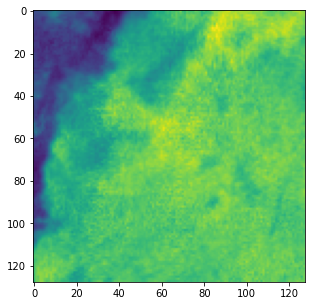

In [20]:
img_show(img, n_channels=125)

In [50]:
dataset[0][0].reshape(125, -1).T.shape

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [56]:
batch_size = 30
ipca = IncrementalPCA(n_components=3)
val_cutoff = int(len(dataset) * 0.9)
for batch in range(batch_size, val_cutoff, batch_size):
    if batch == val_cutoff:
        img_batch = np.vstack([dataset[num][0].reshape(125, -1).T for num in range(val_cutoff // batch_size * batch_size, val_cutoff)])
    else:
        img_batch = np.vstack([dataset[num][0].reshape(125, -1).T for num in range(batch - batch_size, batch)])
    ipca.partial_fit(img_batch)
    print(f"Progress: {int(batch / val_cutoff * 100)}%")

Progress: 1%
Progress: 3%
Progress: 5%
Progress: 6%
Progress: 8%
Progress: 10%
Progress: 11%
Progress: 13%
Progress: 15%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 21%
Progress: 23%
Progress: 25%
Progress: 26%
Progress: 28%
Progress: 30%
Progress: 31%
Progress: 33%
Progress: 35%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 41%
Progress: 43%
Progress: 45%
Progress: 46%
Progress: 48%
Progress: 50%
Progress: 51%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 61%
Progress: 63%
Progress: 65%
Progress: 67%
Progress: 68%
Progress: 70%
Progress: 72%
Progress: 73%
Progress: 75%
Progress: 77%
Progress: 78%
Progress: 80%
Progress: 82%
Progress: 83%
Progress: 85%
Progress: 87%
Progress: 88%
Progress: 90%
Progress: 92%
Progress: 93%
Progress: 95%
Progress: 97%
Progress: 98%


In [87]:
dump(ipca, "ipca")

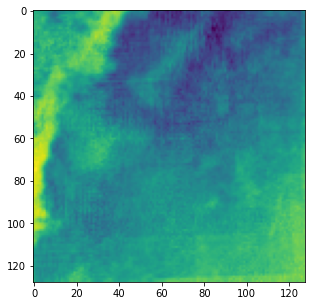

In [82]:
trans_img = ipca.transform(img.reshape(125, -1).T).T.reshape(3, 128, 128)


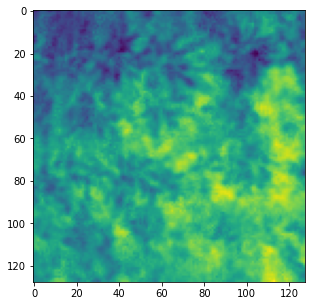

In [75]:
trans_img = dataset[120][0]
img_show(trans_img, n_channels=3)

In [76]:
trans_img[1, 50: 60, 50: 60]

array([[ 7.59955136,  8.85885166, 10.25113208, 10.64322468, 11.69436996,
        12.0409348 , 14.66320326, 18.04870944, 16.45664684, 14.10700756],
       [ 4.67185455,  5.68668443,  6.57229981,  7.93909694, 10.20496998,
        11.54245363, 14.45018585, 16.67401554, 16.06872116, 13.59673385],
       [ 4.17617013,  5.40647084,  5.91853501,  8.60183153, 11.02309952,
        12.78224956, 13.76315187, 14.80905166, 16.07125422, 13.20080273],
       [ 5.36238233,  5.52202694,  7.03742979, 10.20113844, 11.6752378 ,
        13.0382497 , 12.84469038, 13.97531594, 15.35343809, 13.0074284 ],
       [ 6.74617092,  6.88213165,  7.64521274, 10.0516052 , 12.00389787,
        14.00744223, 13.57569968, 14.06909063, 14.91397271, 12.62803192],
       [ 6.61973643,  7.42505592,  7.60947044,  9.16812019, 10.88651576,
        13.51570461, 14.37304125, 14.67800878, 14.4296564 , 11.82213243],
       [ 6.17445705,  7.4103975 ,  7.83783709,  8.20126083,  8.95320629,
        11.77822787, 14.28350346, 15.68061546

In [6]:
cat_boost = CatBoostRegressor(random_state=42)
batch_size_train = 200
batch_size_val = 199

In [7]:
train_ds, val_ds = random_split(dataset, [0.9, 0.1])
print(len(train_ds), len(val_ds))
train_dl = DataLoader(train_ds, batch_size_train, shuffle=True)
val_dl = DataLoader(val_ds, batch_size_val, shuffle=False)

1791 199


In [140]:
len(train_ds) // batch_size

8

In [145]:
for (x_train_batch, y_train_batch), (x_val_batch, y_val_batch) in zip(train_dl, val_dl):
    x_train_batch = x_train_batch.numpy().reshape(200, -1)
    print(x_train_batch.shape)

(200, 49152)


In [33]:
next(iter(val_dl))[1].numpy()

array([ 46,   6,  72,  26,  77,  15,  77,   7,  87,  70,  87,  34,  41,
        60,  73,  77,  92,  36,  54,  41,  32,  44,  61,  40, 100,   8,
       100,   0,  32,  79,  14,  87,   9,   4,  78,  33,  85,  27,  28,
         4,   2,   2,  78,  97,  79,  56,  79, 100, 100,  94,   5,  80,
        24,  63,  71,  74,  96,  80,  54,  57,  40,  61,  24,   6,  14,
        16,   7,  92,   8,  71,  54,  31,  24,  12,  28,  30,  54,  78,
         3,  32,  66,  68,  15,  56,  12,  12,  42,  22,  88,  23,  51,
        84,   2,  12,  29,  46,  30,  19,  76,  85, 100,  70,  49,  73,
         6,   4,  88,   7,  42,  95,  20,  15,  63,  66,  41,  42,  93,
        11,  34,  70,  68,  48,  55,  30,  28,  27,  19,   1, 100,  48,
         6,  88,  29,  19,  34,  20,  60,  23,  21,  44,  58,  85,  66,
        46,  67,  58,  99,   5,   6,  68,  95,  83,  80,  45,  41,  88,
        23,   8,  42,  63,  70, 100,  82,  15,  18,  18,  34,  94,  41,
        59,   5,  41,  40,  39,  22,  21,  71,  22,  51,  18,  9

In [37]:
models = []
iteration = 0
for x_train_batch, y_train_batch in train_dl:
    x_train_batch, y_train_batch = x_train_batch.numpy().reshape(batch_size_train, -1), y_train_batch.numpy()
    x_val_batch, y_val_batch = next(iter(val_dl))[0].numpy().reshape(batch_size_val, -1), next(iter(val_dl))[1].numpy()
    batch_train = Pool(x_train_batch, label=y_train_batch)
    batch_val = Pool(x_val_batch, label=y_val_batch)
    cat_boost = CatBoostRegressor(random_state=42, silent=True)
    if iteration == 0:
        cat_boost.fit(X=batch_train, eval_set=batch_val, early_stopping_rounds=50)
    else: 
        batch_train.set_baseline(models[iteration - 1].predict(batch_train))
        batch_val.set_baseline(models[iteration - 1].predict(batch_val))
        cat_boost.fit(X=batch_train, eval_set=batch_val, early_stopping_rounds=50)
    models.append(cat_boost)
    print(f"Progress : {round(batch_size_train * (iteration + 1) / len(train_ds) * 100, 2)}")
    iteration += 1

Progress : 11.17
Progress : 22.33
Progress : 33.5
Progress : 44.67
Progress : 55.83
Progress : 67.0
Progress : 78.17
Progress : 89.34


ValueError: cannot reshape array of size 9388032 into shape (200,newaxis)

In [88]:
model = sum_models(models)
model.save_model("catboost.cb")

In [49]:
class AgriPredDataset(Dataset):
    def __init__(self, root_dir, num_channels=125, include_pca=True):
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)), 
            transforms.Normalize(mean=means,
                                std=stds)
        ])
        self.root_dir = Path(root_dir)
        self.test_dir = Path(self.root_dir) / "ot" / "ot"
        self.num_channels = num_channels
        self.include_pca = include_pca
        if self.include_pca:
            self.pca = load("ipca")
        self.samples = []
        labels = pd.read_csv(self.root_dir / "test.csv")
        for label in labels.values:
            self.samples.append((self.test_dir / label[0], int(re.findall(r'\d+', label[0])[0])))
                    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, img_id = self.samples[idx]
        image = np.load(img_path).astype(float)
        image = image.transpose(2, 1, 0)
        image = torch.tensor(image, dtype=torch.float)
        
        if self.transform:
            image = self.transform(image).numpy()

        if self.include_pca:
            image = self.pca.transform(image.reshape(125, -1).T).T.reshape(3, 128, 128)
            
        return image, img_id

In [51]:
test_dataset = AgriPredDataset(root_dir=r"C:\Users\User\OneDrive\Документы\Kaggle\kaggle\AI for agriculture 2025")

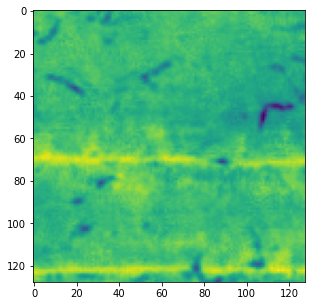

In [72]:
trans_img = test_dataset[120][0]
img_show(trans_img, n_channels=3)

In [116]:
trans_img[0, 50: 60, 50: 60]

array([[ -9.14524766,  -7.92919683,  -6.73947149,  -6.45116149,
         -5.63145423,  -5.4549716 ,  -3.01077006,   0.1613982 ,
         -1.52572734,  -4.06407656],
       [-12.01938942, -11.07182712, -10.37495781,  -9.12322789,
         -7.08236546,  -5.89168541,  -3.15567   ,  -1.12514241,
         -1.85328112,  -4.45528257],
       [-12.39183287, -11.24588169, -10.9062222 ,  -8.36350399,
         -6.17607205,  -4.57738267,  -3.71203453,  -2.81742848,
         -1.77974211,  -4.75369515],
       [-11.18366486, -11.10638291,  -9.79531827,  -6.76996442,
         -5.52790185,  -4.32872052,  -4.60626476,  -3.62258188,
         -2.46139488,  -4.93153872],
       [ -9.79161773,  -9.7370892 ,  -9.17526553,  -6.92635172,
         -5.20547727,  -3.37008035,  -3.88442857,  -3.52352994,
         -2.894895  ,  -5.30611226],
       [ -9.86631792,  -9.13817084,  -9.13925253,  -7.76680309,
         -6.25648948,  -3.82777545,  -3.08311329,  -2.91939975,
         -3.28992429,  -6.02192996],
       [-1

In [53]:
test_batch_size = 1
test_dl = DataLoader(test_dataset, test_batch_size, shuffle=False)

In [108]:
for test_batch, id in test_dl:
        test_batch = test_batch.numpy().reshape(1, -1)
        #img_show(test_batch, n_channels=3)
        print(test_batch[0].shape)
        break

(49152,)


In [111]:
def predict(model, test_dl, name):
    predictions = []
    for test_batch, id in test_dl:
        test_batch = test_batch.numpy().reshape(1, -1)[0]
        pred = model.predict(test_batch)
        predictions.append((f"sample{id[0]}.npy", pred))
    predictions = pd.DataFrame(predictions, columns=["ID", "TARGET"])
    predictions.to_csv(f"{name}.csv", index=False)
    return predictions

<AxesSubplot:>

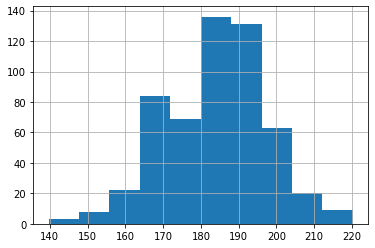

In [112]:
predictions = predict(model, test_dl=test_dl, name="catboost")
predictions["TARGET"].hist()

array([[<AxesSubplot:title={'center':'TARGET'}>]], dtype=object)

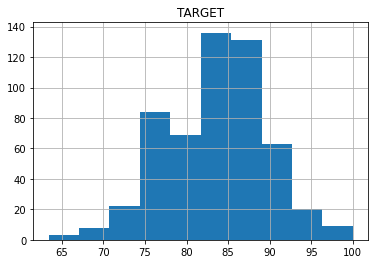

In [122]:
pred_new = predictions.copy()
pred_new["TARGET"] = predictions["TARGET"] / predictions["TARGET"].max() * 100
pred_new.hist()

In [87]:
pred_new.to_csv("catboost.csv", index=False)